<a href="https://colab.research.google.com/github/filippobrizzi/myutils/blob/master/Fast_Corner_Detection_SOLUTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Interview

Interview structure, 1 hour 30 min total:
* 15 min introducing the problem.
* 1 hour coding on your own.
* 15 min discussing the solution together.

##Question
### FAST corner detection
Given a grayscale image, detect all keypoints on the image using a FAST corner detector.

###Details
* Use only the standard C++ library in the implementation, plus the provided code. The code should not have third-party dependencies.
  * Feel free to modify the provided code if needed.
* You can browse the internet for any resource.
* Work on the standard FAST algorithm (not the machine learning one).

### Focus
Your focus should be (in order of importance):
* Correctness: the code does what it is expected.
* Design: correctly break down the code into functions and classes.
* Performance: the code is optimal in speed and accuracy

> Consider the non-maximal suppression step as a bonus. Focus on design and performance of the other steps before tackling it.



## Code

### Prepare environment

In [ ]:
%%script bash
apt-get install -y -qq libopencv-dev python3-opencv

wget -O van.webp https://public.das.arrival.com/src/images/2a36deb2-d9c4-429f-b13b-ef052c1eb646_Configurator_Image_1_1.webp


Selecting previously unselected package python3-numpy.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../python3-numpy_1%3a1.13.3-2ubuntu1_amd64.deb ...
Unpacking python3-numpy (1:1.13.3-2ubuntu1) ...
Selecting previously unselected package python3-opencv.
Preparing to unpack .../python3-opencv_3.2.0+dfsg-4ubuntu0.1_amd64.deb ...
Unpacking python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Setting up python3-numpy (1:1.13.3-2ubuntu1) ...
/usr/lib/python3.8/subprocess.py:842: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stdin = io.open(p2cwrite, 'wb', bufsize)
Setting up python3-opencv (3.2.0+dfsg-4ubuntu0.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


--2022-12-19 10:58:15--  https://public.das.arrival.com/src/images/2a36deb2-d9c4-429f-b13b-ef052c1eb646_Configurator_Image_1_1.webp
Resolving public.das.arrival.com (public.das.arrival.com)... 172.64.153.193, 104.18.34.63, 2606:4700:4400::6812:223f, ...
Connecting to public.das.arrival.com (public.das.arrival.com)|172.64.153.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45078 (44K) [image/webp]
Saving to: ‘van.webp’

     0K .......... .......... .......... .......... ....      100% 4.00M=0.01s

2022-12-19 10:58:15 (4.00 MB/s) - ‘van.webp’ saved [45078/45078]



### Write your main code here

This script writes the content of the code snipped to `main.cpp`

In [ ]:
%%writefile CMakeLists.txt

cmake_minimum_required(VERSION 3.5)

project(FAST_corner)

set(CMAKE_CXX_STANDARD 17)
find_package(OpenCV REQUIRED)
include_directories(${OpenCV_INCLUDE_DIRS})
add_executable(fast_corner main.cpp)
target_link_libraries(fast_corner ${OpenCV_LIBS})


Writing CMakeLists.txt


In [ ]:
%%writefile fast_corner_support.h
#include <vector>
#include <cstdint>

struct Corner {
  Corner(int u, int v) : u(u), v(v) {}
  int u = -1;
  int v = -1;
};

//# NOTE: feel free to change or add code to this class if needed.
struct Image {
  Image(int cols, int rows) : cols(cols), rows(rows) {
    data.resize(cols * rows, 0);
  }
  Image(int cols, int rows, std::vector<uint8_t> data) : cols(cols), rows(rows), data(std::move(data)) {
  }
  Image() = default;

  auto operator()(int col, int row) -> uint8_t& {
    return data[row * cols + col];
  }
  auto operator()(int col, int row) const -> uint8_t {
    return data[row * cols + col];
  }

  int cols;
  int rows;
  std::vector<uint8_t> data;
};



Writing fast_corner_support.h


In [ ]:
%%writefile fast_corner.h
#include "fast_corner_support.h"

#include <vector>
#include <array>

struct FASTCornerDetectorParams{
  int threshold = 10;
  int contiguos_pixels = 12;
};

constexpr std::array<std::pair<int, int>, 16> circle_idx_offset = {{
  {0, 3},
  {1, 3},
  {2, 2},
  {3, 1},
  {3, 0},
  {3, -1},
  {2, -2},
  {1, -3},
  {0, -3},
  {-1, -3},
  {-2, -2},
  {-3, -1},
  {-3, 0},
  {-3, 1},
  {-2, 2},
  {-1, 3}
}};

auto bresenhamCircle(const Image& src, int u, int v) -> std::array<uint8_t, 16> {
    std::array<uint8_t, 16> pixels;
    for (int i = 0; i < 16; ++i) {
        int uc = u + circle_idx_offset[i].first;
        int vc = v + circle_idx_offset[i].second;
        pixels[i] = src(uc, vc);
    }
    return pixels;
}

auto isFastCorner(const Image& src, int u, int v, int threshold, int contiguos_pixels) -> bool {
    auto pixels = bresenhamCircle(src, u, v);
    auto ip = src(u, v);
    auto ip_plus_t = ip + threshold;
    auto ip_minus_t = ip - threshold;
    int current_contiguos_pixels = 0;
    uint8_t previous = 0;
    bool one_loop_completed = false;
    for (int i = 0; i < 16; ++i) {
        auto px = pixels[i];
        if (px > ip_plus_t) {
            if (previous > ip_plus_t) {
                if (++current_contiguos_pixels >= contiguos_pixels) {
                    return true;
                }
            } else {
                current_contiguos_pixels = 1;
            }
        } else if (px < ip_minus_t) {
            if (previous < ip_minus_t) {
                if (++current_contiguos_pixels >= contiguos_pixels) {
                    return true;
                }
            } else {
                current_contiguos_pixels = 1;
            }
        } else {
            current_contiguos_pixels = 0;
        }
        previous = px;

        if (i == 15 && !one_loop_completed) {
            i = -1;
            one_loop_completed = true;
        }
    }
    return false;
}


auto cornerFAST(const Image& src, const FASTCornerDetectorParams& params) -> std::vector<Corner> {
  std::vector<Corner> corners;
  for (int col = 3; col < src.cols-3; ++col) {
      for (int row = 3; row < src.rows-3; ++row) {
          if (isFastCorner(src, col, row, params.threshold, params.contiguos_pixels)) {
              corners.emplace_back(Corner(col, row));
          }
      }
  }
  return corners;
}




Writing fast_corner.h


In [ ]:
%%writefile main.cpp
#include "fast_corner.h"

#include <algorithm>
#include <iostream>
#include <cstdint>
#include <vector>
#include <fstream>

#include "opencv2/highgui/highgui.hpp"
#include "opencv2/opencv.hpp"

auto convert(const cv::Mat &mat) -> Image {
  std::vector<uint8_t> array(mat.total() * mat.channels());
  array.assign(mat.data, mat.data + mat.total() * mat.channels());
  return Image(mat.cols, mat.rows, array);
}

auto paintCorners(const cv::Mat &mat, const std::vector<Corner> corners)
    -> cv::Mat {
  cv::Mat dst;
  mat.copyTo(dst);
  for (const auto &corner : corners) {
    cv::circle(dst, cv::Point(corner.u, corner.v), 5, cv::Scalar(255, 255, 255), 2, 8, 0);
  }
  return dst;
}

auto cornerFAST_demo(const cv::Mat &src)
    -> std::vector<Corner> {
  auto fast = cv::FastFeatureDetector::create();
  std::vector<cv::KeyPoint> keypoints;
  fast->detect(src, keypoints);
  std::vector<Corner> corners;
  for (const auto& kp: keypoints) {
    corners.emplace_back(Corner(kp.pt.x, kp.pt.y));
  }
  return corners;
}

auto getInputImage() -> cv::Mat {
  cv::Mat img = cv::imread("van.webp", cv::IMREAD_GRAYSCALE);
  if (img.channels() == 3) {
      cv::cvtColor(img, img, cv::COLOR_RGB2GRAY);
  }
  cv::resize(img, img, cv::Size(642, 400));
  cv::imwrite("van.png", img);
  return img;
}

int main(int argc, char **argv) {
  auto img = getInputImage();

  auto corners_cv = cornerFAST_demo(img);
  cv::imwrite("van_kp_cv.png", paintCorners(img, corners_cv));

  cv::Mat blur;
  cv::blur(img, blur, cv::Size(3,3));
  auto arr = convert(blur);
  FASTCornerDetectorParams params{};
  auto corners = cornerFAST(arr, params);
  cv::imwrite("van_kp.png", paintCorners(img, corners));
  return 0;
}


Writing main.cpp


### Build and run

Make sure you first run the `write main.cpp` script before

In [ ]:
%%script bash
mkdir -p build
cd build
cmake ..
make -j8

-- The C compiler identification is GNU 7.5.0
-- The CXX compiler identification is GNU 7.5.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found OpenCV: /usr (found version "3.2.0") 
-- Configuring done
-- Generating done
-- Build files have been written to: /content/build
[ 50%] Building CXX object CMakeFiles/fast_corner.dir/main.cpp.o
[100%] Linking CXX executable fast_corner
[100%] Built target fast_corner


In [ ]:
%%script bash
./build/fast_corner

### Check output

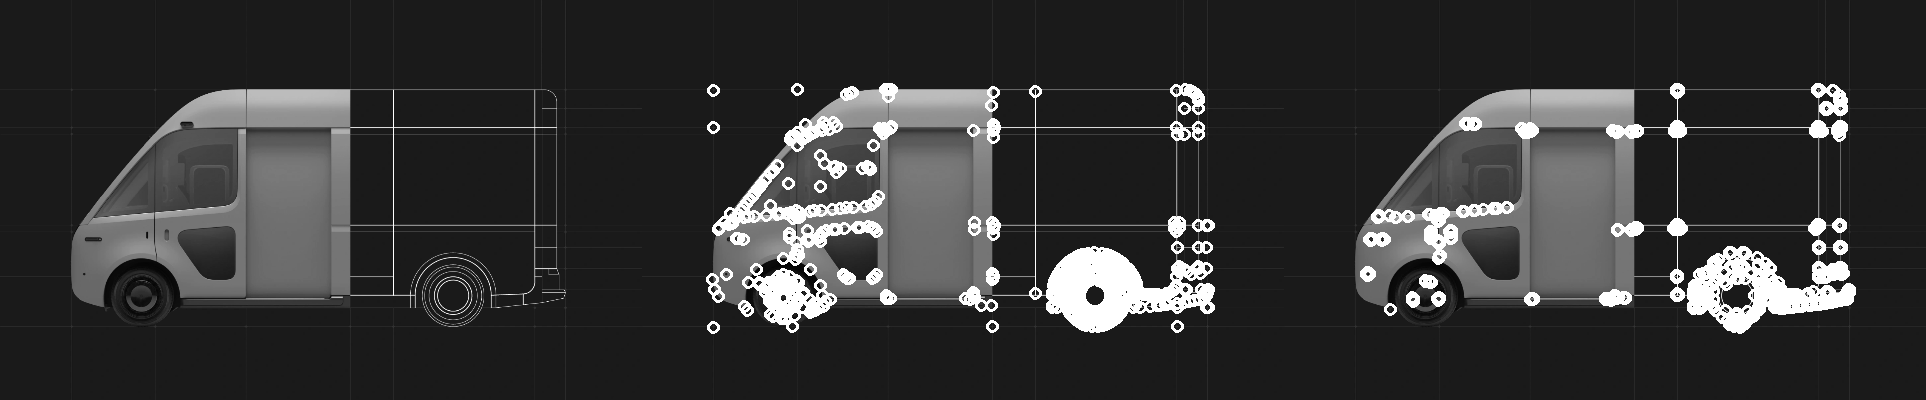

In [ ]:
from google.colab.patches import cv2_imshow
import numpy as np
import cv2

img = cv2.imread('van.png', cv2.IMREAD_GRAYSCALE)
img_kp_cv = cv2.imread('van_kp_cv.png', cv2.IMREAD_GRAYSCALE)
img_kp = cv2.imread('van_kp.png', cv2.IMREAD_GRAYSCALE)
horizontal = np.hstack((img, img_kp_cv, img_kp))
cv2_imshow(horizontal)